In [3]:
cd /Users/joepalmo/Desktop/cfa/SDU-preproc

/Users/joepalmo/Desktop/cfa/SDU-preproc


In [4]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from astropy.io import ascii
import os

# open source module found for converting MJD/JD to DateTimes
import jdutil as jd

# Ben's module -- THANKS BEN
import LCtools

# my preprocessing module
from preproc import *

import glob


In [5]:
# specify path to the lightcurve and spectrum
lc_path = "GRB/GRB161023A_LightCurve.txt"
spec_path = "GRB/GRB161023A_spec2AA.txt"

# object name (or abbreviation)
n = "GRB"

# resample length for time-sorted LC purposes
resample_len = '1min'

# Time Sorted Light Curve

In [6]:
#load into pandas dataframes
lc = pd.read_csv(lc_path, delimiter='\t', skiprows=1, names=['DaysPostTrigger', 'JulianDay', 'magRc', 'err_magRc'])

In [7]:
lc['mjd'] = jd.jd_to_mjd(lc['JulianDay'])

In [8]:
lc

,DaysPostTrigger,JulianDay,magRc,err_magRc,mjd
0,0.000534,2.457685e+06,15.736,0.027,57684.944184
1,0.000609,2.457685e+06,14.534,0.028,57684.944259
2,0.000689,2.457685e+06,16.039,0.039,57684.944339
3,0.000764,2.457685e+06,15.646,0.035,57684.944414
4,0.000878,2.457685e+06,15.942,0.031,57684.944528
...,...,...,...,...,...
187,5.467250,2.457691e+06,21.969,0.180,57690.410900
188,6.082950,2.457692e+06,22.080,0.050,57691.026600
189,6.082950,2.457692e+06,22.064,0.050,57691.026600
190,6.082950,2.457692e+06,22.067,0.090,57691.026600


In [9]:
lc['logDaysPostTrigger'] = np.log10(lc['DaysPostTrigger'])

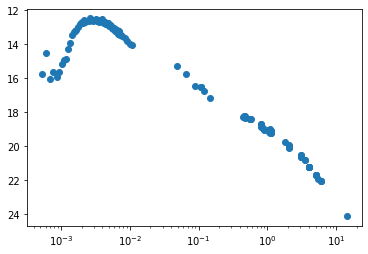

In [10]:
plt.scatter(lc['DaysPostTrigger'], lc['magRc'])
plt.xscale('log')
plt.gca().invert_yaxis()

In [11]:
def format_df1(arr, bins, rephased):
    """
    Function used to format phased LC data into a pandas df that can be input into sonoUno. This means
    binning, averaging, and extending x-axis across 2 phases.
    """
    # bin by phase -> 100 points
    s, edges, _ = binned_statistic(arr[:,0],arr[:,1], statistic='mean', bins=bins)
    bincenters = edges[:-1]+np.diff(edges)/2
    
    #to df - name columns
    new_arr = np.vstack((bincenters, s)).T
    df = pd.DataFrame(new_arr, columns = ['Phase', 'Magnitude'])

    if rephased is True:
        rephase = df[df.Phase.between(0.505, 1.495)]['Magnitude'].to_numpy()
        rephase = np.append(rephase, rephase)
        rephase_arr = np.vstack((bincenters, rephase)).T
        rephase_df = pd.DataFrame(rephase_arr, columns=['Phase', 'Magnitude'])

        return rephase_df
    
    return df


In [12]:
log_arr = np.vstack((lc['logDaysPostTrigger'], lc['magRc'])).T

In [13]:
logbins = np.arange(-3.25,1.2,0.02)

In [14]:
time_preproc_lc = format_df1(log_arr, logbins, False).rename(columns={'Phase':'logDaysPostTrigger'})

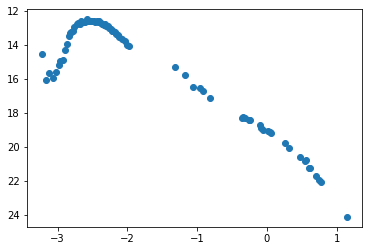

In [15]:
plt.scatter(time_preproc_lc['logDaysPostTrigger'], time_preproc_lc['Magnitude'])
plt.gca().invert_yaxis()

In [16]:
time_preproc_lc['DaysPostTrigger'] = 10 ** time_preproc_lc['logDaysPostTrigger']

In [17]:
len(time_preproc_lc)

222

In [18]:
len(time_preproc_lc.dropna())

77

In [19]:
# The average data play rate determined empirically from sonoUno is about 
# 8.5 data rows played per second. Therefore:
print("Estimated video time of "+ str(len(time_preproc_lc) / 8.5), "s")

Estimated video time of 26.11764705882353 s


# Spectra

In [20]:
spec = pd.read_csv(spec_path, delimiter='\s+')

In [21]:
spec

,wavelength,flux
0,3200.0,0.358719
1,3202.0,0.088948
2,3204.0,0.049704
3,3206.0,-0.186613
4,3208.0,-0.347598
...,...,...
8895,20990.0,0.161854
8896,20992.0,0.247326
8897,20994.0,0.277530
8898,20996.0,0.134004


In [22]:
preproc_spec = spectra_preproc(spec, bins=np.arange(4440,6610,10))

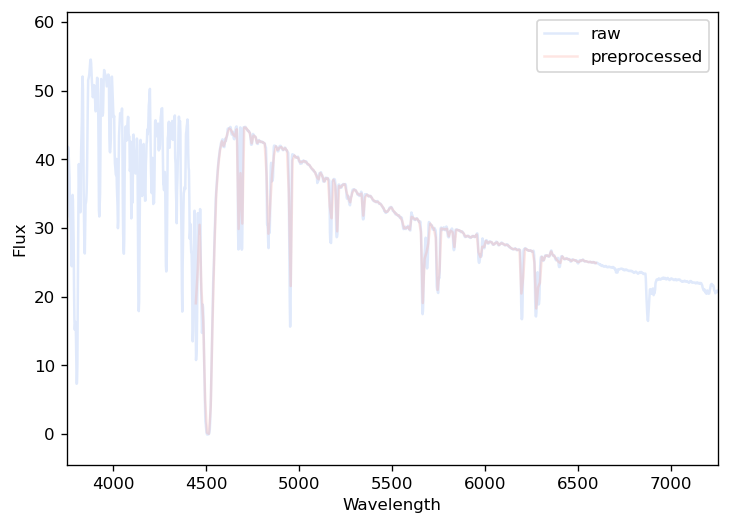

In [23]:
fig2 = plot_spectra(spec, preproc_spec)

In [24]:
len(preproc_spec) / 8.5

25.41176470588235

# Save Preprocessed Files

In [25]:
#create output directory
outdir = 'preproc/{}/'.format(n)
if not os.path.exists(outdir):
    os.makedirs(outdir)   

In [26]:
#save preprocessed files
time_preproc_lc.to_csv("preproc/{}/{}_LC_timesort.csv".format(n,n), index=False)
preproc_spec.to_csv("preproc/{}/{}_spec.csv".format(n,n), index=False)